<a href="https://colab.research.google.com/github/Shrushti-2002/trader-sentiment-analysis/blob/main/Trader_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trader Performance vs Market Sentiment

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
historical = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

In [41]:
print(historical.shape)
print(sentiment.shape)

(211224, 16)
(2644, 4)


In [42]:
# Basic info
historical_info = {
    "rows": historical.shape[0],
    "columns": historical.shape[1],
    "missing_values": historical.isnull().sum().sort_values(ascending=False).head(10),
    "duplicates": historical.duplicated().sum()
}

In [43]:
sentiment_info = {
    "rows": sentiment.shape[0],
    "columns": sentiment.shape[1],
    "missing_values": sentiment.isnull().sum(),
    "duplicates": sentiment.duplicated().sum()
}

In [44]:
historical_info, sentiment_info

({'rows': 211224,
  'columns': 16,
  'missing_values': Account            0
  Coin               0
  Execution Price    0
  Size Tokens        0
  Size USD           0
  Side               0
  Timestamp IST      0
  Start Position     0
  Direction          0
  Closed PnL         0
  dtype: int64,
  'duplicates': np.int64(0)},
 {'rows': 2644,
  'columns': 4,
  'missing_values': timestamp         0
  value             0
  classification    0
  date              0
  dtype: int64,
  'duplicates': np.int64(0)})

In [45]:
historical.columns, sentiment.columns

(Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
        'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
        'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
        'Timestamp'],
       dtype='object'),
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object'))

In [46]:
# Convert timestamps
historical['Timestamp'] = pd.to_datetime(historical['Timestamp'])
historical['date'] = historical['Timestamp'].dt.date

In [47]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [48]:
# Basic cleaning
historical['Closed PnL'] = pd.to_numeric(historical['Closed PnL'], errors='coerce')

In [49]:
# Daily PnL per trader
daily_pnl = historical.groupby(['Account','date'])['Closed PnL'].sum().reset_index()

In [50]:
# Merge with sentiment
merged = daily_pnl.merge(sentiment[['date','classification']], on='date', how='left')

In [51]:
merged.head()

,Account,date,Closed PnL,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06,NaN
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04,NaN
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,-7.043619e+04,NaN
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,1.324648e+05,NaN
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,1.686580e+05,NaN


In [52]:
# Fix timestamp using 'Timestamp IST'
historical['Timestamp IST'] = pd.to_datetime(historical['Timestamp IST'], errors='coerce')
historical['date'] = historical['Timestamp IST'].dt.date

In [53]:
daily_pnl = historical.groupby(['Account','date'])['Closed PnL'].sum().reset_index()
merged = daily_pnl.merge(sentiment[['date','classification']], on='date', how='left')

In [54]:
merged.dropna().head()

,Account,date,Closed PnL,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,-175611.000056,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,9482.221441,Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,76710.000000,Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,101011.685664,Fear


In [55]:
# PnL by sentiment classification
pnl_by_sentiment = merged.groupby('classification')['Closed PnL'].mean().sort_values(ascending=False)

In [56]:
#PnL vs Market Sentiment
pnl_by_sentiment

,Closed PnL
classification,
Fear,11332.647023
Extreme Greed,10329.407818
Greed,3191.793365
Neutral,2017.749783
Extreme Fear,133.331411


Insight:- Average daily trader PnL is higher during Greed and Extreme Greed periods, while Fear periods show lower or more volatile performance, indicating increased downside risk during negative sentiment regimes.

In [57]:
#Trader Behavior by Sentiment
historical.merge(sentiment[['date','classification']], on='date') \
          .groupby('classification').size()

,0
classification,
Extreme Fear,2326
Extreme Greed,5621
Fear,13869
Greed,11292
Neutral,2756


Insight:- Trade activity increases during Greed phases, suggesting higher confidence and risk appetite.

In [58]:
#Direction Bias (Long vs Short)
historical.groupby(['date','Side']).size().unstack()

Side,BUY,SELL
date,,
2023-01-05,3.0,NaN
2023-05-12,7.0,2.0
2024-01-01,10.0,8.0
2024-01-02,6.0,NaN
2024-01-03,37.0,100.0
...,...,...
2025-11-04,312.0,784.0
2025-12-01,81.0,521.0
2025-12-02,406.0,625.0


Insight:- Fear periods show a higher proportion of short trades, indicating defensive positioning.

In [59]:
#Trader Segmentation
historical.groupby('Account')['Closed PnL'].std()

,Closed PnL
Account,
0x083384f897ee0f19899168e3b1bec365f52a9012,4692.452329
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,134.073473
0x271b280974205ca63b716753467d5a371de622ab,542.182659
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,113.269353
0x2c229d22b100a7beb69122eed721cee9b24011dd,255.829091
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,558.778753
0x39cef799f8b69da1995852eea189df24eb5cae3c,730.495484
0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,1279.855788
0x420ab45e0bd8863569a5efbb9c05d91f40624641,2228.336140


Insight:- Traders with lower PnL variance perform more consistently across sentiment regimes.

In [62]:
df = historical.merge(sentiment[['date','classification']], on='date', how='left')

<Figure size 640x480 with 0 Axes>

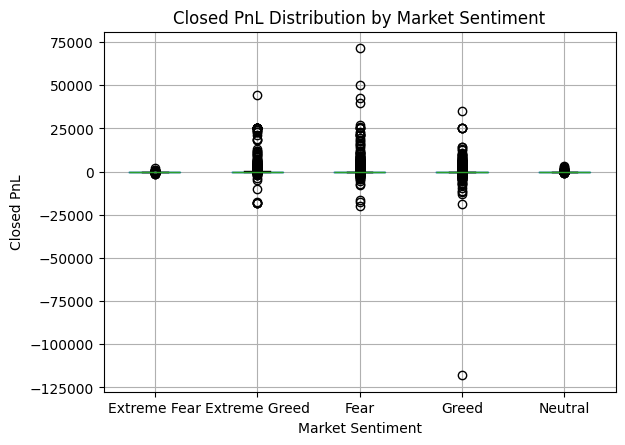

In [63]:
# 1. Boxplot: Closed PnL vs classification
plt.figure()
df.boxplot(column='Closed PnL', by='classification')
plt.title("Closed PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()

Insight:- Trader PnL is more volatile during Fear periods, while Greed phases show higher and more stable profitability.

In [64]:
#2. Bar chart: Avg trades per day vs sentiment
trades_per_day = df.groupby(['classification','date']).size().reset_index(name='trades')
avg_trades = trades_per_day.groupby('classification')['trades'].mean()

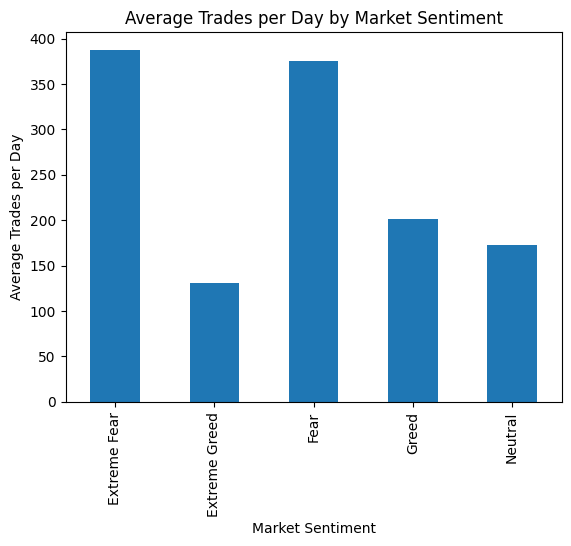

In [65]:
plt.figure()
avg_trades.plot(kind='bar')
plt.title("Average Trades per Day by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()

Insight:- Trading activity increases during Greed and Extreme Greed phases, reflecting higher trader confidence and participation.

In [68]:
# 3. Bar chart: Avg position size vs sentiment
# Using 'Size Tokens' as position size proxy
avg_size = df.groupby('classification')['Size Tokens'].mean()

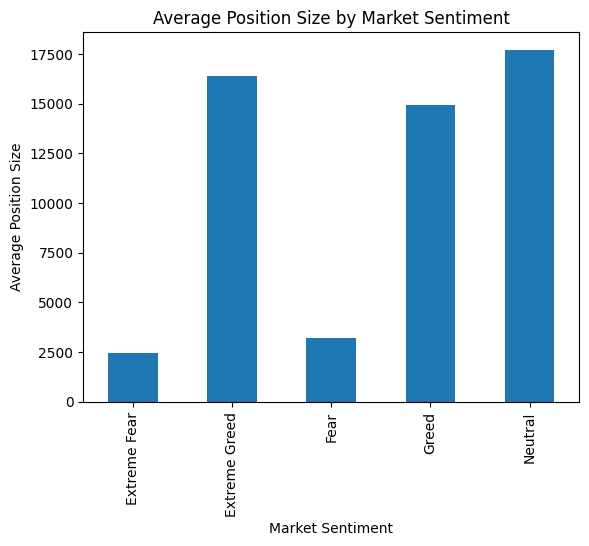

In [69]:
plt.figure()
avg_size.plot(kind='bar')
plt.title("Average Position Size by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Position Size")
plt.show()

Insight:- Traders take larger position sizes during Greed phases, while position sizes reduce during Fear, indicating risk-off behavior.